In [2]:
from sklearn.preprocessing import LabelEncoder
labels = ['entertainment', 'food', 'travel', 'health and lifestyle', 'mom and children', 'fashion', 'tech', 'sports', 'art', 'gaming']

label_encoder = LabelEncoder()
label_encoder.fit(labels)

LabelEncoder()

In [3]:
from sklearn.preprocessing import TargetEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
from consts import *

FILENAME = get_filename(TT.ALL, EMBED_PROVIDER.OPENAI, MEAN_METHOD.MEAN)
print(FILENAME)

df_embeds = pd.read_parquet(FILENAME)
df_train_all = pd.read_parquet('data/training-dataset.parquet')

df_train = pd.merge(df_embeds, df_train_all[['username','category_enum','label']], how='left', on='username')
df_train = df_train.dropna(subset=['label'])
df_train = df_train.drop(columns=['username'])
df_train['category_enum'] = df_train['category_enum'].fillna('Missing')

df_train


df_train['target'] = label_encoder.transform(df_train['label'])
df_train = df_train.drop(columns=['label'])


X = df_train.drop(columns=['target'])
y = df_train[['target']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



encoder = TargetEncoder()
cat_encoded_train = encoder.fit_transform(X_train["category_enum"].to_numpy().reshape(-1,1), y_train['target'].tolist())
X_train['category_encoded'] = [row.tolist() for row in cat_encoded_train]
X_train = X_train[['embeds_wavg','category_encoded']]

X_train = pd.concat([pd.DataFrame(X_train['category_encoded'].tolist()), pd.DataFrame(X_train['embeds_wavg'].tolist())],axis=1)



cat_encoded_test = encoder.transform(X_test['category_enum'].to_numpy().reshape(-1,1))
X_test['category_encoded'] = [row.tolist() for row in cat_encoded_test]
X_test = pd.concat([pd.DataFrame(X_test['category_encoded'].tolist()), pd.DataFrame(X_test['embeds_wavg'].tolist())],axis=1)

X_train, X_test, y_train, y_test = X_train.to_numpy(), X_test.to_numpy(), y_train.to_numpy(), y_test.to_numpy()



data/embeddings/openai-t3-large/ue_em_mean.parquet


In [4]:
X_train.shape

(1918, 3082)

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


clf = RandomForestClassifier(
    n_estimators=500,        # Number of trees in the forest
    max_depth=25,            # Maximum depth of each tree
    max_features='sqrt',     # Number of features to consider at each split (sqrt(522) ≈ 23)
    min_samples_split=5,     # Minimum samples required to split an internal node
    min_samples_leaf=2,      # Minimum samples required to be at a leaf node
    class_weight='balanced', # Handle imbalanced classes (optional)
    random_state=42,         # Ensure reproducibility
    n_jobs=-1                # Use all CPU cores for parallel processing
)
clf.fit(X_train, y_train)

# Predict on test data
y_pred = clf.predict(X_test)

# Evaluate

/home/tagrikli/Desktop/Academic/Courses/CS412   - Machine Learning/Term Project/Data Modelling/env/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.11      0.17        66
           1       0.52      0.54      0.53        92
           2       0.75      0.87      0.80        99
           3       0.92      0.95      0.93       161
           4       0.00      0.00      0.00         5
           5       0.59      0.78      0.67       144
           6       0.69      0.51      0.59        39
           7       0.85      0.63      0.72        35
           8       0.73      0.89      0.80        95
           9       0.79      0.62      0.69        86

    accuracy                           0.72       822
   macro avg       0.63      0.59      0.59       822
weighted avg       0.70      0.72      0.69       822


Additional Metrics:
Accuracy: 0.7153
Macro F1: 0.5916
Weighted F1: 0.6942
Macro Precision: 0.6292
Macro Recall: 0.5899


/home/tagrikli/Desktop/Academic/Courses/CS412   - Machine Learning/Term Project/Data Modelling/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tagrikli/Desktop/Academic/Courses/CS412   - Machine Learning/Term Project/Data Modelling/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tagrikli/Desktop/Academic/Courses/CS412   - Machine Learning/Term Project/Data Modelling/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: 

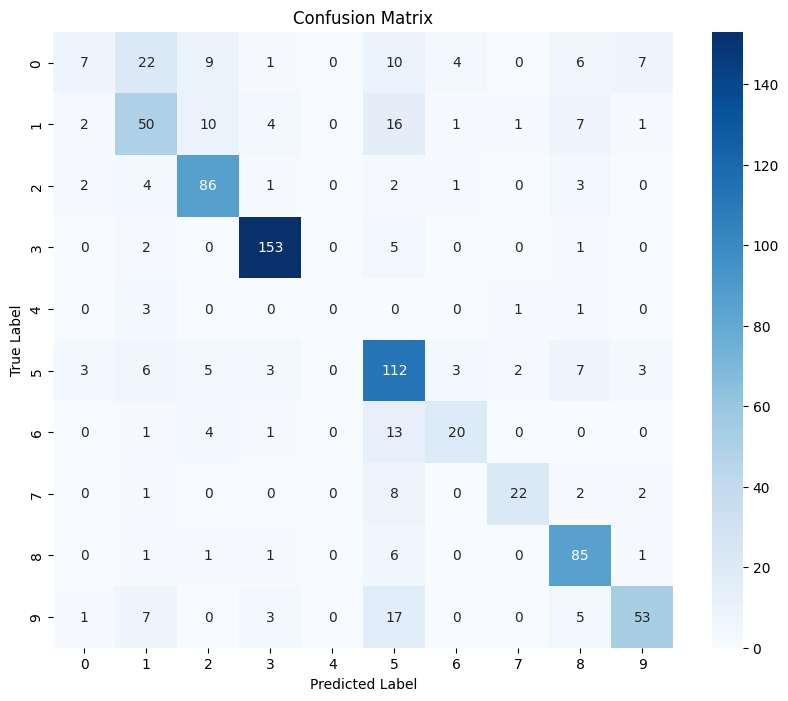

In [6]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Print detailed metrics
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))

# Calculate additional metrics
accuracy = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average='macro')
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
macro_precision = precision_score(y_test, y_pred, average='macro')
macro_recall = recall_score(y_test, y_pred, average='macro')

print("\nAdditional Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro F1: {macro_f1:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}")
print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()



In [7]:
label_encoder.inverse_transform([9,5, 0 ,1, 5])

array(['travel', 'health and lifestyle', 'art', 'entertainment',
       'health and lifestyle'], dtype='<U20')

In [8]:
from sklearn.preprocessing import LabelEncoder, TargetEncoder
from sklearn.model_selection import train_test_split

df_train = pd.merge(df_embeds, df_train_all[['username','category_enum','label']], how='left', on='username')
df_train = df_train.dropna(subset=['label'])
df_train = df_train.drop(columns=['username'])
df_train['category_enum'] = df_train['category_enum'].fillna('Missing')



labels = ['entertainment', 'food', 'travel', 'health and lifestyle', 'mom and children', 'fashion', 'tech', 'sports', 'art', 'gaming']



label_encoder = LabelEncoder()
label_encoder.fit(labels)

print(label_encoder.transform(['art']))

df_train['target'] = label_encoder.transform(df_train['label'])
df_train = df_train.drop(columns=['label'])


X = df_train.drop(columns=['target'])
y = df_train[['target']]
X_train = X
y_train = y


encoder = TargetEncoder()
cat_encoded_train = encoder.fit_transform(X_train["category_enum"].to_numpy().reshape(-1,1), y_train['target'].tolist())
X_train['category_encoded'] = [row.tolist() for row in cat_encoded_train]
X_train = X_train[['embeds_wavg','category_encoded']]

X_train = pd.concat([pd.DataFrame(X_train['category_encoded'].tolist()), pd.DataFrame(X_train['embeds_wavg'].tolist())],axis=1)



X_train, y_train = X_train.to_numpy(), y_train.to_numpy()


#model = fit_predict_eval(X_train, y_train)


[0]
